In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from mintpy.utils import readfile, utils as ut 
from mintpy.objects import timeseries
import cartopy.crs as ccrs
from mintpy import view
import datetime
from operator import itemgetter 
import h5py
from minopy.objects.invert_pixel import process_pixel 
import matplotlib.dates as mdates
from minopy.find_short_baselines import get_baselines_dict
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]



def get_dates_ts(proj_dir, points_lalo, refy, refx, reftype, win_s=5):
    from mintpy.objects import timeseries   
  
    tsStack = proj_dir + '/{}'.format('timeseries_SET_ERA5_demErr.h5')
    gStack = '/Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/inputs/geometryRadar.h5'
    atr = readfile.read_attribute(tsStack)
    coord = ut.coordinate(atr, gStack)
    stack_obj = timeseries(tsStack)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    ts = np.zeros([len(points_lalo), num_dates])
    
    for t, coord in enumerate(points_lalo):
    
        if reftype == 'lalo':
            dates, ts[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack, lookup_file=gStack, 
                                                      ref_lat=refy, ref_lon=refx, win_size=win_s, unit='cm', 
                                                      print_msg=True)[0:2]
        if reftype =='yx':
            dates, ts[t, :] = ut.read_timeseries_yx(coord[0], coord[1], tsStack, ref_y=refy, ref_x=refx, 
                                                    win_size=win_s, unit='cm', print_msg=True)[0:2]
    
        
    x_values = [date.timetuple().tm_yday for date in dates]
    x = np.zeros([len(x_values),1])
    m = 0
    for t, value in enumerate(x_values):
        x[t] = value
        if t > 0: 
            if value < x[t-1]:
                if value < x_values[t-1]:
                    m += 360
                    x[t] += m
                else:
                    x[t] += m
                
    x = [y - x[0] for y in x]
    return dates, x, ts



center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [41]:


lat_P665 = 40.4555 
lon_P665= -121.5263 

lat_P667 = 40.4666 
lon_P667 = -121.4679 


points_lalo = [(lat_P665, lon_P665),
               (lat_P667, lon_P667)]

reflat = 40.540 
reflon = -121.577 


prj_dir = '/Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042'

project_dirs = [prj_dir + '/single_reference',
                prj_dir + '/delaunay_6',
                prj_dir + '/mini_stacks',
                prj_dir + '/seq_3']

data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]


geom_file = project_dirs[0] + '/inputs/geometryRadar.h5'

box = ['40.3632:40.6334','-121.6971:-121.3132']

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]


baselines, dates = get_baselines_dict(prj_dir + '/old/inputs/baselines')
out_dir = './out_figures'

In [13]:
def read_ds(proj_dir):
    velocity_file = proj_dir + '/geocoded/geo_velocity.h5'
    velocity_file2 = proj_dir + '/geocoded/geo_vel_2020.h5'
    geometry_file = proj_dir + '/geocoded/geo_geometryRadar.h5'
    mask_file_t = proj_dir + '/geocoded/geo_maskTempCoh.h5'
    latitude = readfile.read(geometry_file, datasetName='latitude')[0]
    longitude = readfile.read(geometry_file, datasetName='longitude')[0]
    
    
    mask = np.ones(latitude.shape, dtype=np.int8)
    

    velocity = readfile.read(velocity_file, datasetName='velocity')[0]
    velocity2 = readfile.read(velocity_file2, datasetName='velocity')[0]
    mask = readfile.read(mask_file_t, datasetName='mask')[0]
    
    vel = np.array(velocity[mask==1]*1000)
    vel2 = np.array(velocity2[mask==1]*1000)
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    
    return lat, lon, vel, vel2
    

In [5]:
# referencing
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    #!reference_point.py $velfile -l $reflat -L $reflon --lookup $geom_file
    #!reference_point.py $velfile -x $refx -y $refy --lookup $geom_file

In [5]:
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    tsfile = prj + '/timeseries_ERA5_demErr.h5'
    temp_coh = prj + '/temporalCoherence.h5'
    #!mask.py $prj_dir/inverted/tempCoh_full -m $prj_dir/shadow_mask.h5 -o $temp_coh
    geocode_dir = prj + '/geocoded'
    os.makedirs(geocode_dir, exist_ok=True)
    !geocode.py $velfile -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !geocode.py $temp_coh -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !generate_mask.py $geocode_dir/geo_temporalCoherence.h5 -m .5 -o $geocode_dir/geo_maskTempCoh.h5

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (40.31460604120117, 40.682568636201175, -121.74816235568359, -121.25538507068359)
output file row / column number: (1987, 2661)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/velocity.h5
update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/velocity.h5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/geo_velocity.h5 with w mode
create dataset 

create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/mini_stacks/geocoded/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (1987, 2661)         with compression=None
finished writing to /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/mini_stacks/geocoded/geo_maskTempCoh.h5
time used: 00 mins 0.1 secs.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (40.31460604120117, 40.682568636201175, -121.74816235568359, -121.25538507068359)
output file row / column number: (1987, 2661)
searching relevant box covering the current SNWE
--

nearest resampling with pyresample.kd_tree using 1 CPU cores in 6 segments ...
write data in block [0, 1987, 0, 2661] to file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/seq_3/geocoded/geo_temporalCoherence.h5
time used: 00 mins 12.6 secs.

input temporalCoherence file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/seq_3/geocoded/geo_temporalCoherence.h5
read /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/seq_3/geocoded/geo_temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
create HDF5 file: /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/seq_3/geocoded/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (1987, 2661)         with compression=None
finished writing to /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/seq_3/geocoded/geo_maskTempCoh.h5
time used: 00 mins 0.2 secs.


view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --noverbose --notitle --ref-lalo 40.54 -121.577 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/delaunay_6/geocoded/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --noverbose --notitle --ref-lalo 40.54 -121.577 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/mini_stacks/geocoded/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --su

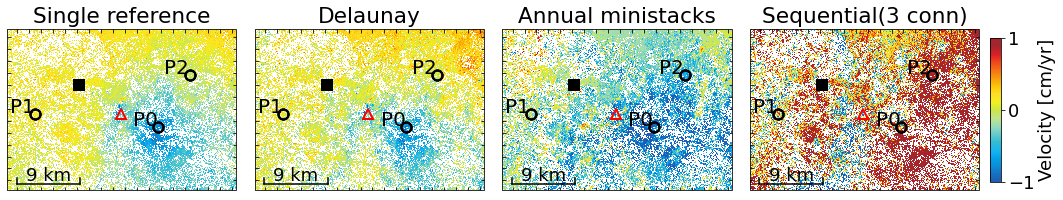

In [43]:
data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]
#data = [x + '/geocoded_sub/geo_vel_2020.h5' for x in project_dirs]

dem_file = os.path.expanduser('./Lassen_data/dem.dem.wgs84')

points_lalo = np.array([(40.491, -121.507)])  #volcanoes



points_lalo1 = np.array([(40.4728 , -121.4966), 
                        (40.4555, -121.5263),
                        (40.4666, -121.4679)]) 

points_lalo1 = np.array([(40.4697 , -121.4438), 
                        (40.4917, -121.6499),
                        (40.5571, -121.3917)]) 

labels1 = ['P0', 'P1', 'P2']

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "18"

titles = ['Single reference','Delaunay','Annual ministacks',  'Sequential(3 conn)']

reflat = 40.540 
reflon = -121.577 

fsize = 12

box = ['40.3632:40.6334','-121.6971:-121.3132']

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]


factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 18 --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
#opt += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az -45 '.format(dem_file)
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
opt += ' --noverbose  --notitle --ref-lalo {} {}'.format(reflat, reflon)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(4):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity'.format(data[t]) + opt 
    cmd += ' -v -{f} {f} '.format(f=1)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    '''
    if t == 0:
        ax.scatter(lonn, latt, c=vel1_si/10, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 1:
        im=ax.scatter(lonn, latt, c=vel1_mi/10, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 2:
        ax.scatter(lonn, latt, c=vel1_de/10, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    else:
        ax.scatter(lonn, latt, c=vel1_se/10, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
    '''   

    for x in range(points_lalo.shape[0]):
       
        #ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, labels[x], fontsize=20, 
        #        horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], '^', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='r', markeredgewidth=2, transform=ccrs.PlateCarree())
        
        ax.plot(reflon, reflat, 's', markersize=10, markerfacecolor='k', 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        
    
    for x in range(points_lalo1.shape[0]):
       
        ax.text(points_lalo1[x,1]-0.001, points_lalo1[x,0]+0.002, labels1[x], fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo1[:,1], points_lalo1[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
    
    ax.set_title(titles[t])
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-1,0,1], label='Velocity [cm/yr]')
#fig.colorbar(im, cax=cbar_ax, label='Velocity (cm/yr)')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      


out_file = os.path.abspath(out_dir + '/3_velocity_lassen_mib.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

In [44]:
reflat = 40.540 
reflon = -121.577 

dates_sr, x_sr, ts_sr = get_dates_ts(project_dirs[0], points_lalo1, reflat, reflon, 'lalo')  # single reference
dates_de, x_de, ts_de = get_dates_ts(project_dirs[1], points_lalo1, reflat, reflon, 'lalo')  # delaunay
dates_ms, x_ms, ts_ms = get_dates_ts(project_dirs[2], points_lalo1, reflat, reflon, 'lalo')  # mini stacks
dates_se3, x_se3, ts_se3 = get_dates_ts(project_dirs[3], points_lalo1, reflat, reflon, 'lalo')  # sequential

for i, date in enumerate(dates):
    if datetime.datetime.strptime(date, '%Y%m%d') not in dates_sr:
        del dates[i]

input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882
input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882
input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882
input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882


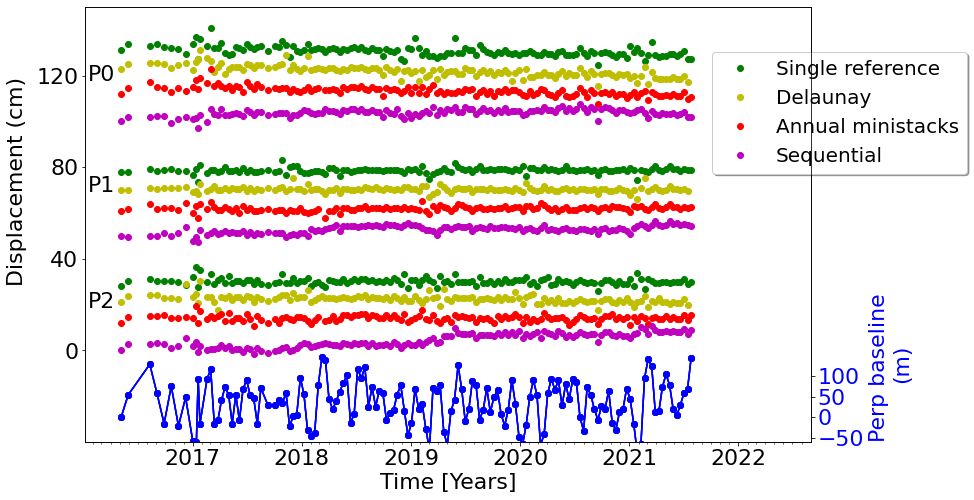

In [125]:
plt.rcParams["font.size"] = "22"
plt.rcParams["legend.framealpha"] = '0.5'
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [50,35,20,0]
lsh = np.array([[31,23,12,0],
                [28,20,11,0],
               [28,21,12,0]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [100, 50, 0]

labels = ['Single reference','Delaunay','Annual ministacks', 'Sequential']

ax1 = axs
ax2 = ax1.twinx()

bslines = np.array([baselines[x] for x in np.sort(dates)])

for t in range(len(points_lalo1)):
    ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + lsh[t,0]+ shift[t], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] + lsh[t,1]+ shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] + lsh[t,2]+ shift[t], 'ro',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0] + lsh[t,3]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    
    ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    
    '''
    ax1.text(dates_ms[-1] + datetime.timedelta(days=20), 
             ts_ms[t, -1] - ts_ms[t, 0] + lsh[t,0]+ shift[t], 
             labels[0], color='g')
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[1], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[2], color='r')
    
    ax1.text(dates_se3[-1] + datetime.timedelta(days=20), 
             ts_se3[t, -1] - ts_se3[t, 0] + lsh[t,3]+ shift[t], 
             labels[3], color='m')
    '''

    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[2, -1] - (ts_de[2, -1]))+ shifts[2]+shift[2], 'P2')

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=120), dates_se3[-1]+datetime.timedelta(days=400))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

ax2.set_ylim(-60, 1000)
ax1.set_ylim(-40, 150)
ax2.set_ylabel('Perp baseline \n(m)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('Displacement (cm)')

ax1.set_xlabel('Time [Years]')

ax1.legend(labels, bbox_to_anchor=(0.85,0.92),shadow=True, fontsize=20)

ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 40, 80, 120))
ax1.yaxis.set_label_coords(-0.08, 0.6)
ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0),
                datetime.datetime(2019, 1, 1, 0, 0),
                datetime.datetime(2020, 1, 1, 0, 0),
                datetime.datetime(2021, 1, 1, 0, 0),
                datetime.datetime(2022, 1, 1, 0, 0)))
plt.savefig(out_dir + '/LAssen_timeseries_unwrap_compare.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


In [128]:
tsStack_minopy = prj_dir + '/old/timeseries_SET_ERA5_demErr.h5'
gStack_minopy = prj_dir + '/old/inputs/geometryRadar.h5'

attr_minopy = readfile.read_attribute(tsStack_minopy)

coord_minopy = ut.coordinate(attr_minopy, gStack_minopy)

# P0
yg_minopy1, xg_minopy1 = coord_minopy.geo2radar(points_lalo1[0][0], points_lalo1[0][1])[0:2]
vec_refined_1, temp_quality_1, coh_mat_1, shp_1, amp_1, data_1, col0_1, row0_1 = process_pixel((yg_minopy1, xg_minopy1), prj_dir + '/old/slcStack.h5')

# P1
yg_minopy2, xg_minopy2 = coord_minopy.geo2radar(points_lalo1[1][0], points_lalo1[1][1])[0:2]
vec_refined_2, temp_quality_2, coh_mat_2, shp_2, amp_2, data_2, col0_2, row0_2 = process_pixel((yg_minopy2, xg_minopy2), prj_dir + '/old/slcStack.h5')

# P2
yg_minopy3, xg_minopy3 = coord_minopy.geo2radar(points_lalo1[2][0], points_lalo1[2][1])[0:2]
vec_refined_3, temp_quality_3, coh_mat_3, shp_3, amp_3, data_3, col0_3, row0_3 = process_pixel((yg_minopy3, xg_minopy3), prj_dir + '/old/slcStack.h5')

(100, 100)
0.5445485189928829
(100, 100)
0.466181023547574
(100, 100)
0.3759845246938889


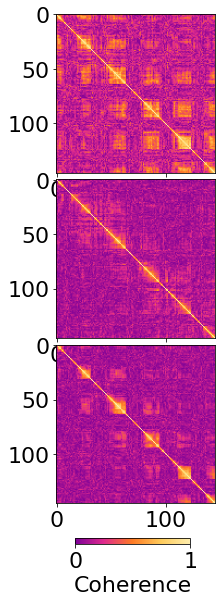

In [136]:
plt.rcParams["font.size"] = "22"
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

ax = axs[0]
im=ax.imshow(np.abs(np.array(coh_mat_1)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[1]
ax.imshow(np.abs(np.array(coh_mat_2)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[2]
ax.imshow(np.abs(np.array(coh_mat_3)), vmin=0, vmax=1, cmap=cmapc)

cbar_ax2 = fig.add_axes([0.42, 0.03, 0.2, 0.01])
#cbar_ax2 = fig.add_axes([0.5, 0.01, 0.005, 0.15, ])
fig.colorbar(im, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')
fig.subplots_adjust(wspace=0.1, hspace=0.04, left=0.1, right=0.95, top=0.95, bottom=0.1)      

plt.savefig(out_dir + '/Lassen_timeseries_unwrap_compare_coh_matrix.png', bbox_inches='tight', transparent=True, dpi=300)
